In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Clean Data

In [247]:
def encode_data(df):
    X = df.drop(['class'], axis=1)
    # drop the most predictive featuers
    # X = df.drop(['class', 'odor','gill-size','bruises', 'ring-type', 'stalk-surface-above-ring', 'spore-print-color', 'population', 'stalk-surface-below-ring',], axis=1)
    # drop just odor 
    # X = df.drop(['class','odor'], axis=1)
    # use only the least predictive features
    # X = df[["cap-shape", "veil-color", "cap-surface","stalk-color-above-ring", "gill-color", "cap-color"]]
    # use only odor
    # X = df["odor"]
    y = df['class'].map({'e':0,'p':1})

    encoded_X = pd.get_dummies(X, drop_first=True).astype(int)
    
    # Add target back
    encoded_df = encoded_X.copy()
    encoded_df['class'] = y
    return encoded_df, encoded_df.drop('class', axis=1), encoded_df['class']

def match_columns(train_X, other_X):
    for col in train_X.columns:
        if col not in other_X.columns:
            other_X[col] = 0  
    return other_X

In [239]:
data = pd.read_csv("mushrooms.csv")

In [240]:
train_df, temp_df = train_test_split(data, test_size=0.3, stratify=data['class'], random_state = 9292, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=.5, stratify=temp_df['class'], random_state = 1, shuffle=True)

encoded_train, train_X, train_y = encode_data(train_df)
encoded_val, val_X, val_y = encode_data(val_df)
encoded_test, test_X, test_y = encode_data(test_df)

val_X = match_columns(train_X, val_X)
test_X = match_columns(train_X, test_X)
val_X = val_X.sort_index(axis=1)
test_X = test_X.sort_index(axis=1)
train_X = train_X.sort_index(axis=1)

In [241]:
train_df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,5686,5686,5686,5686,5686,5686,5686,5686,5686,5686,...,5686,5686,5686,5686,5686,5686,5686,5686,5686,5686
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,2945,2559,2283,1596,3295,2456,5537,4792,3925,1204,...,3459,3124,3062,5686,5545,5252,2797,1660,2811,2218


In [242]:
train_df.isna().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

<Figure size 1200x600 with 0 Axes>

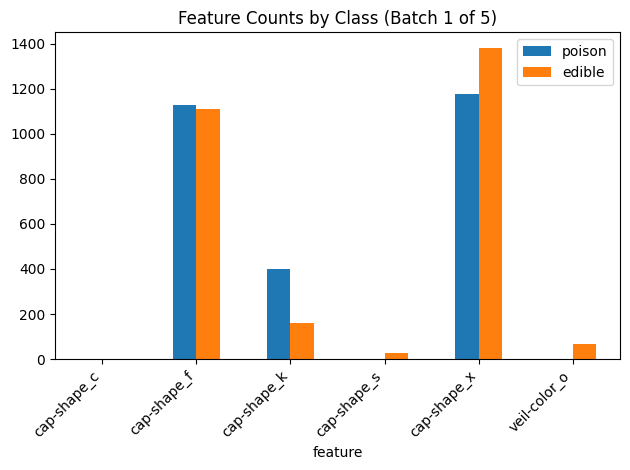

<Figure size 1200x600 with 0 Axes>

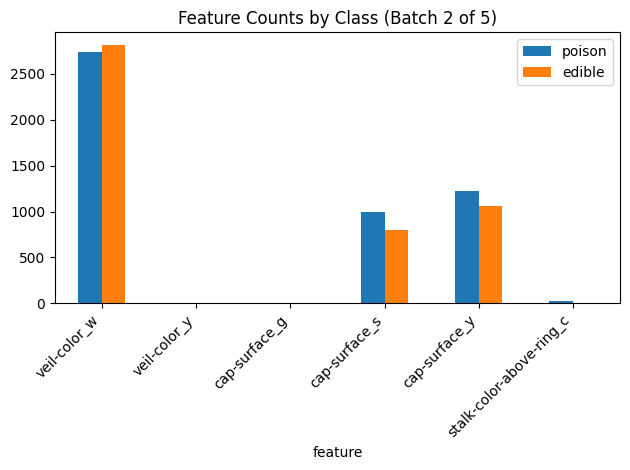

<Figure size 1200x600 with 0 Axes>

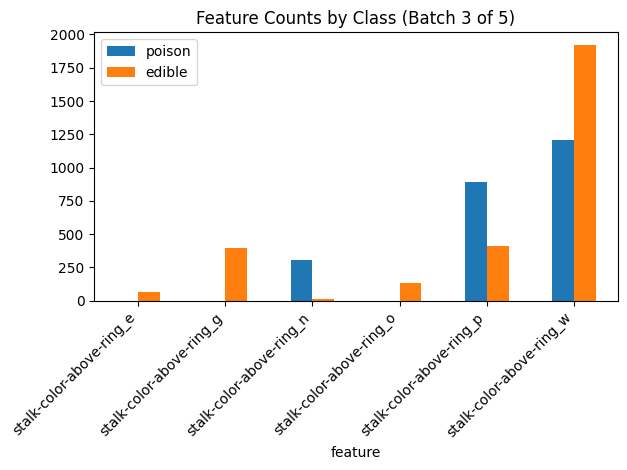

<Figure size 1200x600 with 0 Axes>

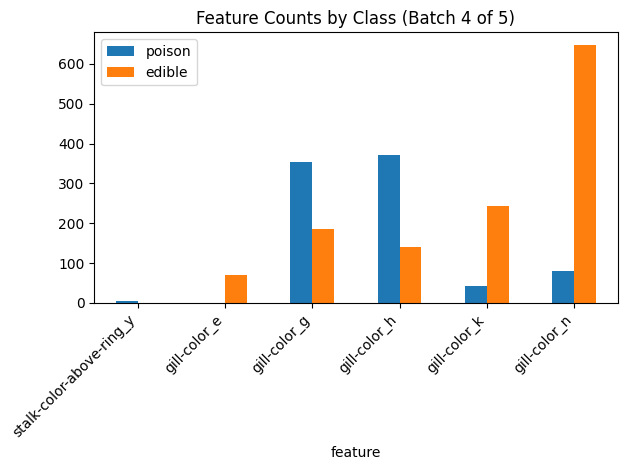

<Figure size 1200x600 with 0 Axes>

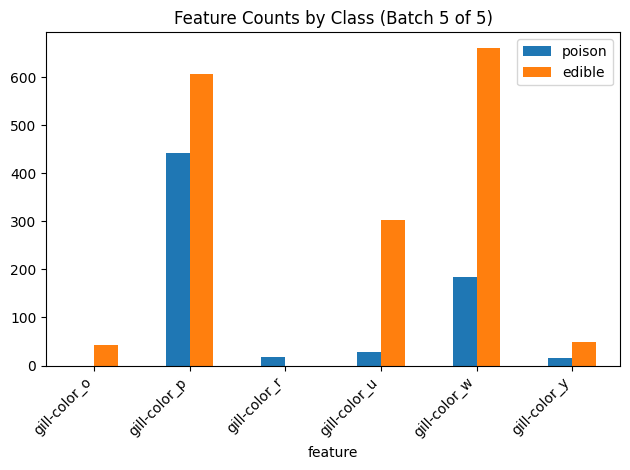

In [243]:
batch_size = 6
# Get list of column names excluding 'class'
feature_cols = [col for col in encoded_train.columns if col != 'class']
n_batches = (len(feature_cols) + batch_size - 1) // batch_size

for i in range(n_batches):
    # Slice the list of column names instead of the DataFrame
    batch_cols = feature_cols[i*batch_size : (i+1)*batch_size]
    counts = []
    
    for col in batch_cols:
        poison_count = encoded_train[encoded_train['class'] == 1][col].sum()
        edible_count = encoded_train[encoded_train['class'] == 0][col].sum()
        counts.append([col, poison_count, edible_count])
    
    count_df = pd.DataFrame(counts, columns=['feature', 'poison', 'edible'])
    plt.figure(figsize=(12, 6))
    count_df.plot(x='feature', y=['poison', 'edible'], kind='bar')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Feature Counts by Class (Batch {i+1} of {n_batches})')
    plt.tight_layout()
    plt.show()

# Create and Train Model

In [244]:
rf_model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=None,    
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=103
)

rf_model.fit(train_X, train_y)

RandomForestClassifier(random_state=103)

# Validate Model

In [245]:
y_pred = rf_model.predict(val_X)
print(classification_report(val_y, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       632
           1       0.92      0.84      0.88       587

    accuracy                           0.89      1219
   macro avg       0.89      0.89      0.89      1219
weighted avg       0.89      0.89      0.89      1219



In [246]:
feature_importance = pd.DataFrame({
    'feature': train_X.columns,
    'importance': rf_model.feature_importances_
})
print("\nTop 10 most important features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))


Top 10 most important features:
                     feature  importance
12              gill-color_n    0.112383
17              gill-color_w    0.105292
25  stalk-color-above-ring_w    0.092858
21  stalk-color-above-ring_g    0.086414
16              gill-color_u    0.079250
6              cap-surface_s    0.071537
14              gill-color_p    0.067801
9               gill-color_g    0.043911
11              gill-color_k    0.043553
24  stalk-color-above-ring_p    0.042714


# Test Model

In [237]:
test_pred = rf_model.predict(test_X)
print(classification_report(test_y, test_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       631
           1       0.94      0.90      0.92       588

    accuracy                           0.92      1219
   macro avg       0.93      0.92      0.92      1219
weighted avg       0.93      0.92      0.92      1219



# Musings

- Odor is nearly perfectly predictive: we get .98 precision and 1 recall with just odor as a predictor
- If we allow the model to use all the data, it is 100% accurate (precision and recall of 1) - odor = "n" or "f" are still two of the most important features, but gill size, stalk surface, and ring size matter among other things
- The model is still able to achieve 100% accuracy without odor! In fact, I had to remove the 10 most predictive features to get below 100%
- You can get to 92% recall and 93% precision with the 6 least predictive features 